## Import libraries and tools

In [89]:
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Calculate equilibrium points of final combined model

In [90]:
# Model parameters
r_J = 0.2
r_N = 0.3
r_H = 0.25
K_0 = 10000
c_JN = c_NJ = 1.0
c_JH = c_NH = c_HJ = c_HN = 0.9
beta_J = beta_N = beta_H = 5e-5
s_H = 1e-5
s_P = 1e-5
m_P = 0.1
gamma = 0.5

# Human intervention functions (assumed constant for equilibrium)
H_J_const = 50  # Stocking of June suckers
H_N_const = -10  # Removal of non-native species
H_H_const = -5  # Removal of hybrids

# Carrying capacity function
def K():
    return K_0 + gamma * H_J_const

# Equilibrium equations
# Define the equilibrium system
def equilibrium_system(vars, t=0):
    J, N, H, P = vars  # Variables to solve for
    dJdt = (
        r_J * J * (1 - (J + c_JN * N + c_JH * H) / K())
        - beta_J * J * P
        - s_H * J * N
        + H_J_const
    )
    dNdt = (
        r_N * N * (1 - (N + c_NJ * J + c_NH * H) / K())
        - beta_N * N * P
        - s_H * J * N
        + H_N_const
    )
    dHdt = (
        s_H * J * N
        + r_H * H * (1 - (H + c_HJ * J + c_HN * N) / K())
        - beta_H * H * P
        + H_H_const
    )
    dPdt = s_P * (J + N + H) * P - m_P * P
    return [dJdt, dNdt, dHdt, dPdt]

# Initial guess
initial_guess = [500, 1000, 0, 50]

# Solve for equilibrium points
equilibrium_points = fsolve(equilibrium_system, initial_guess)

# Print results
J_eq, N_eq, H_eq, P_eq = equilibrium_points
print(f"Equilibrium June Sucker Population (J): {J_eq:.2f}")
print(f"Equilibrium Non-native Species Population (N): {N_eq:.2f}")
print(f"Equilibrium Hybrid Population (H): {H_eq:.2f}")
print(f"Equilibrium Predator Population (P): {P_eq:.2f}")


Equilibrium June Sucker Population (J): -245.62
Equilibrium Non-native Species Population (N): 32.44
Equilibrium Hybrid Population (H): 19.98
Equilibrium Predator Population (P): 0.00


## Create phase plots

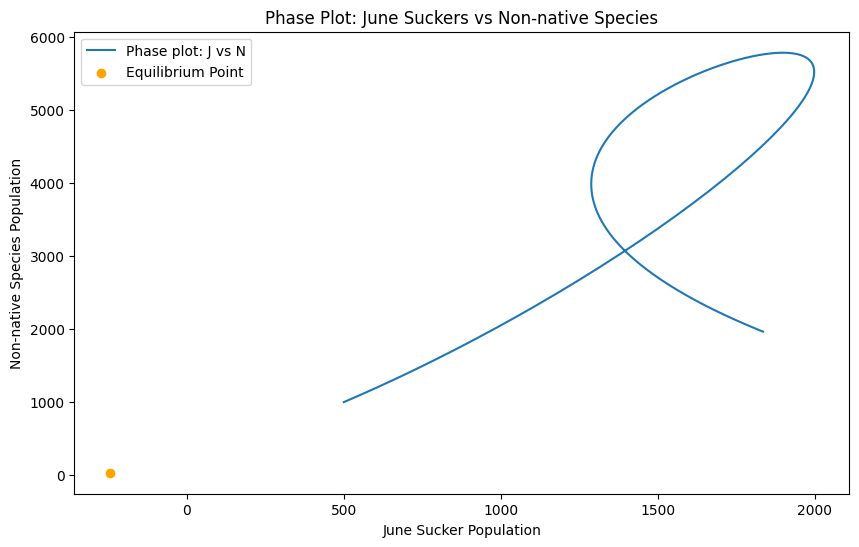

In [91]:
# Time span for the simulation
time = np.linspace(0, 100, 500)

# Solve the ODEs
solution = odeint(equilibrium_system, initial_guess, time)

# Extract the populations from the solution
J, N, H, P = solution.T

# Plot J vs N (Phase plot)
plt.figure(figsize=(10, 6))
plt.plot(J, N, label="Phase plot: J vs N")

# Plot equilibrium point 
plt.scatter([J_eq], [N_eq], color='orange', zorder=5, label="Equilibrium Point")

# Add labels and title
plt.xlabel("June Sucker Population")
plt.ylabel("Non-native Species Population")
plt.title("Phase Plot: June Suckers vs Non-native Species")
plt.legend()

plt.show()


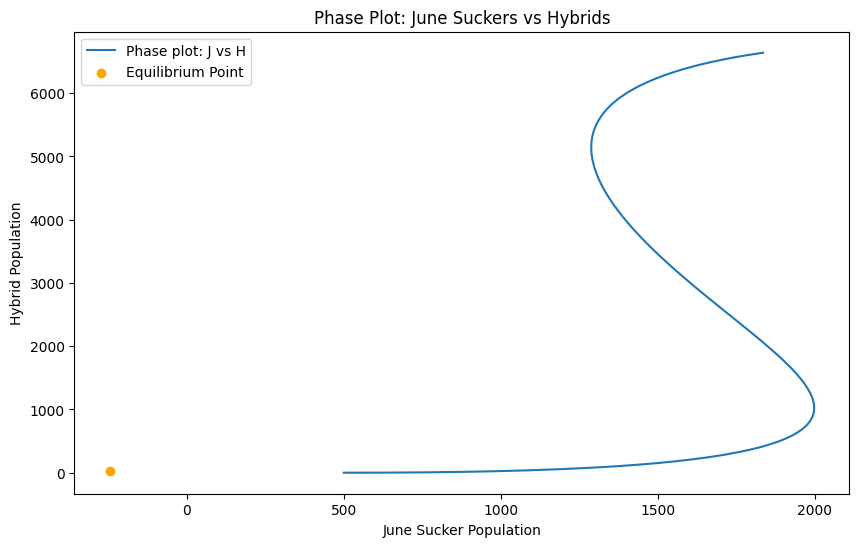

In [92]:
# Plot J vs H (Phase plot)
plt.figure(figsize=(10, 6))
plt.plot(J, H, label="Phase plot: J vs H")

# Plot equilibrium point 
plt.scatter([J_eq], [H_eq], color='orange', zorder=5, label="Equilibrium Point")

# Add labels and title
plt.xlabel("June Sucker Population")
plt.ylabel("Hybrid Population")
plt.title("Phase Plot: June Suckers vs Hybrids")
plt.legend()

plt.show()

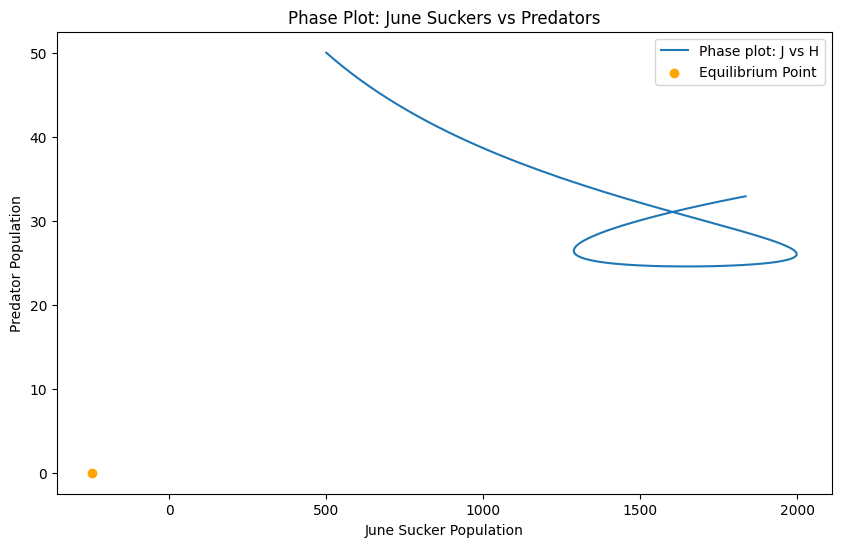

In [93]:
# Plot J vs P (Phase plot)
plt.figure(figsize=(10, 6))
plt.plot(J, P, label="Phase plot: J vs H")

# Plot equilibrium point 
plt.scatter([J_eq], [P_eq], color='orange', zorder=5, label="Equilibrium Point")

# Add labels and title
plt.xlabel("June Sucker Population")
plt.ylabel("Predator Population")
plt.title("Phase Plot: June Suckers vs Predators")
plt.legend()

plt.show()